In [96]:
import pandas as pd
import geopandas
import unicodedata
import sqlite3 
import matplotlib.pyplot as plt


In [18]:
import os
import sys
import time
import datetime
import numpy as np

from tabulate import tabulate

import sqlite3

In [19]:
conn = sqlite3.connect(os.path.join('cursos_prouni.sqlite'))
cur = conn.cursor()

In [22]:
cur.execute('''  
SELECT * FROM cursos_prouni
          ''')
df = pd.DataFrame(cur.fetchall(), columns=['grau', 'turno', 'mensalidade', 'bolsa_integral_cotas', 'bolsa_integral_ampla', 'bolsa_parcial_cotas', 'bolsa_parcial_ampla', 'curso_id', 'curso_busca', 'cidade_busca', 'uf_busca', 'cidade_filtro', 'universidade_nome', 'campus_nome', 'campus_id', 'nome','nota_integral_ampla', 'nota_integral_cotas', 'nota_parcial_ampla','nota_parcial_cotas'])    

In [101]:
# pegando o mapão (substituir por pegar do banco)

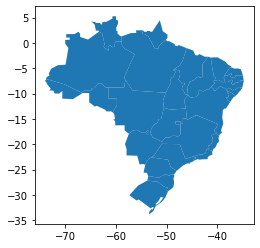

In [24]:
# df = pd.read_csv("cursos-prouni.csv")
file = open("br-states.json")
geodata = geopandas.read_file(file)
df.rename(columns={'uf_busca':'id'}, inplace=True)
df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

 - Relação entre bolsas e notas
 - Relação entre mensalidade e notas

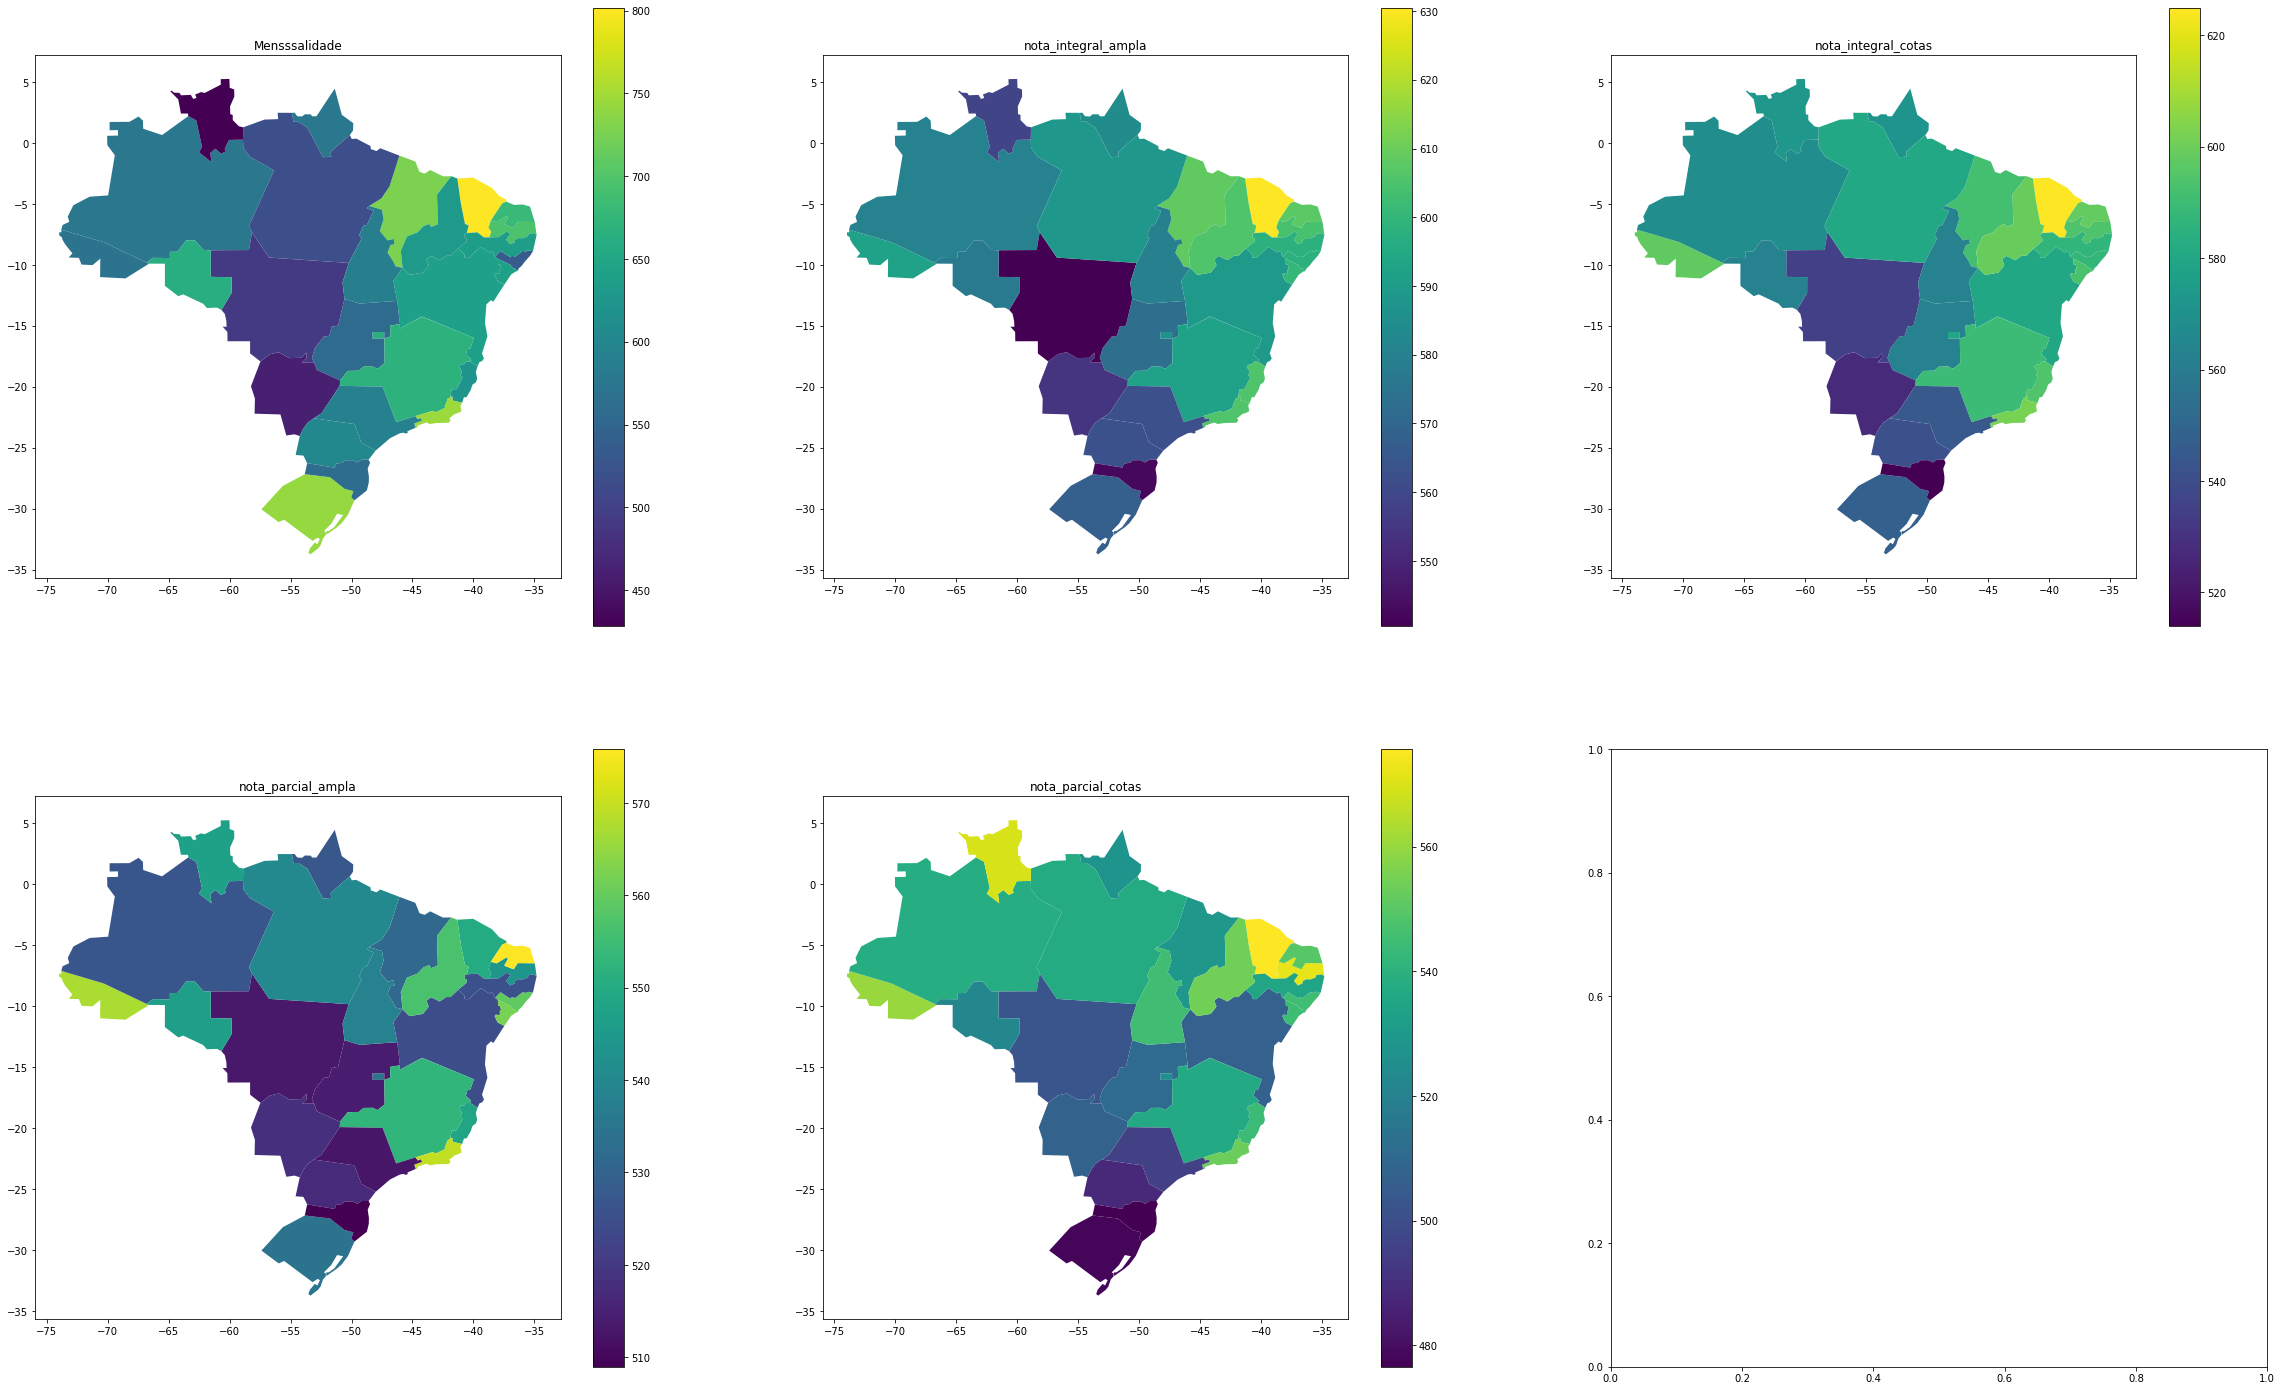

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)


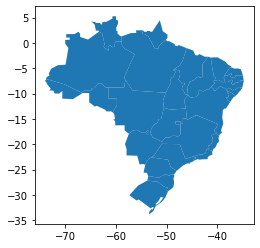

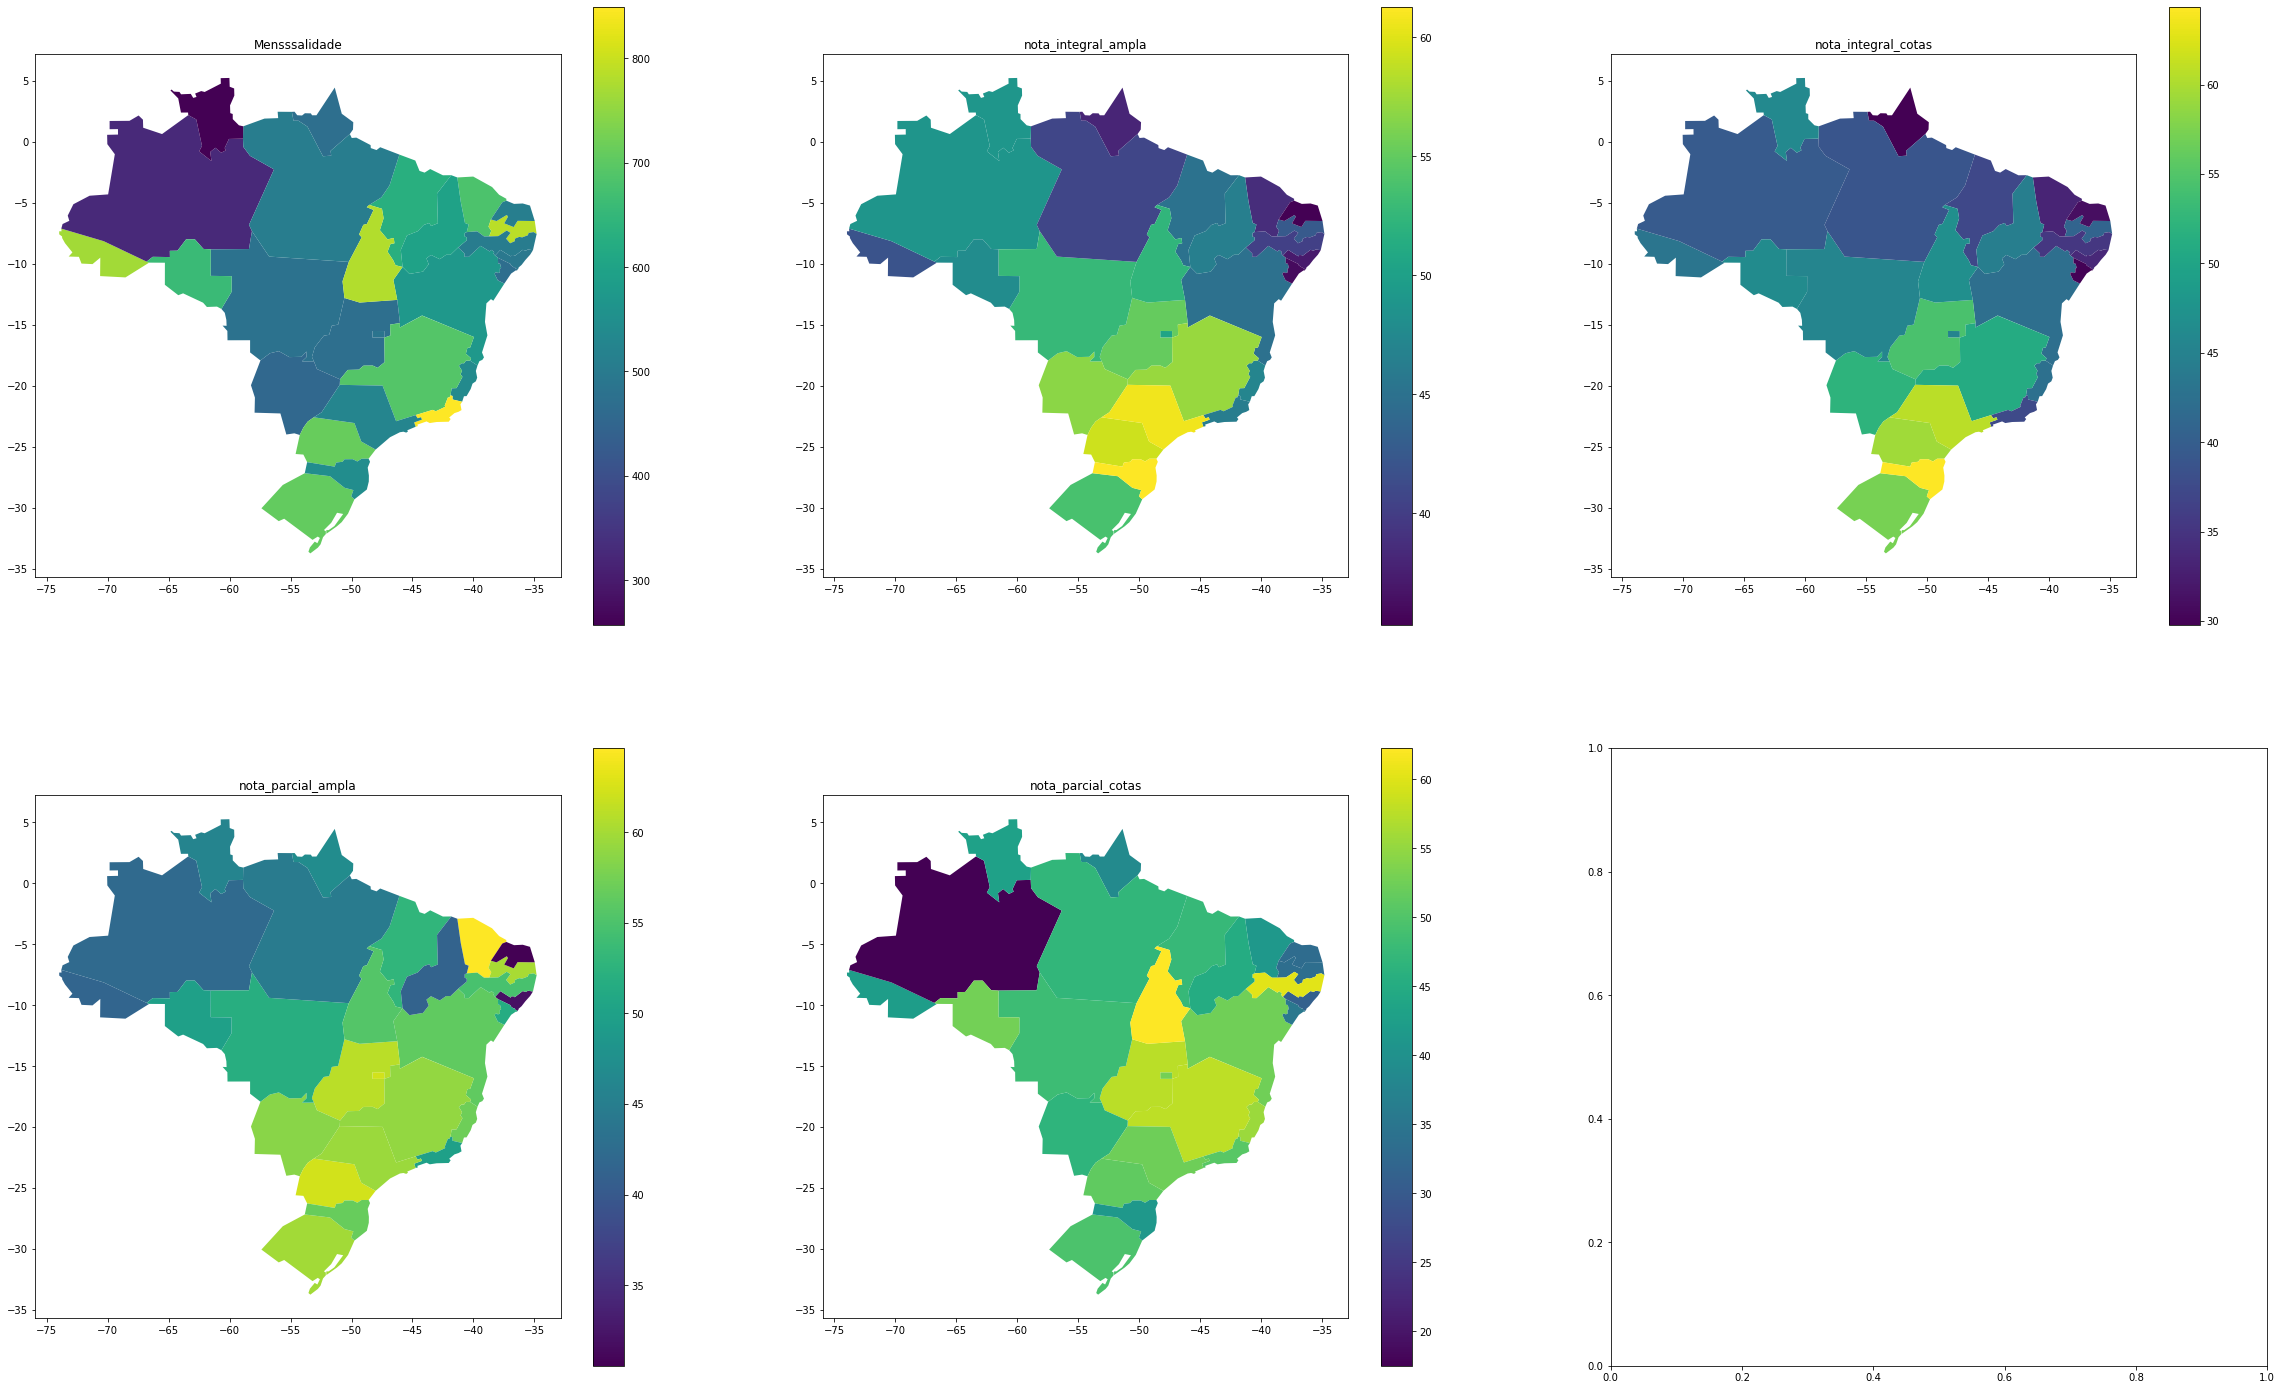

In [26]:
df1=df.groupby("id").std()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("nota_integral_ampla")
axes[0][2].set_title("nota_integral_cotas")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="nota_integral_ampla", ax=axes[0][1], legend=True)
gdf3.plot(column="nota_integral_cotas", ax=axes[0][2], legend=True)
gdf3.plot(column="nota_parcial_ampla", ax=axes[1][0], legend=True)
gdf3.plot(column="nota_parcial_cotas", ax=axes[1][1], legend=True)

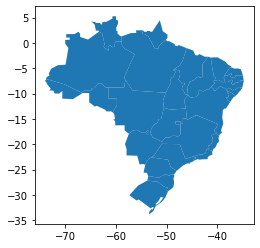

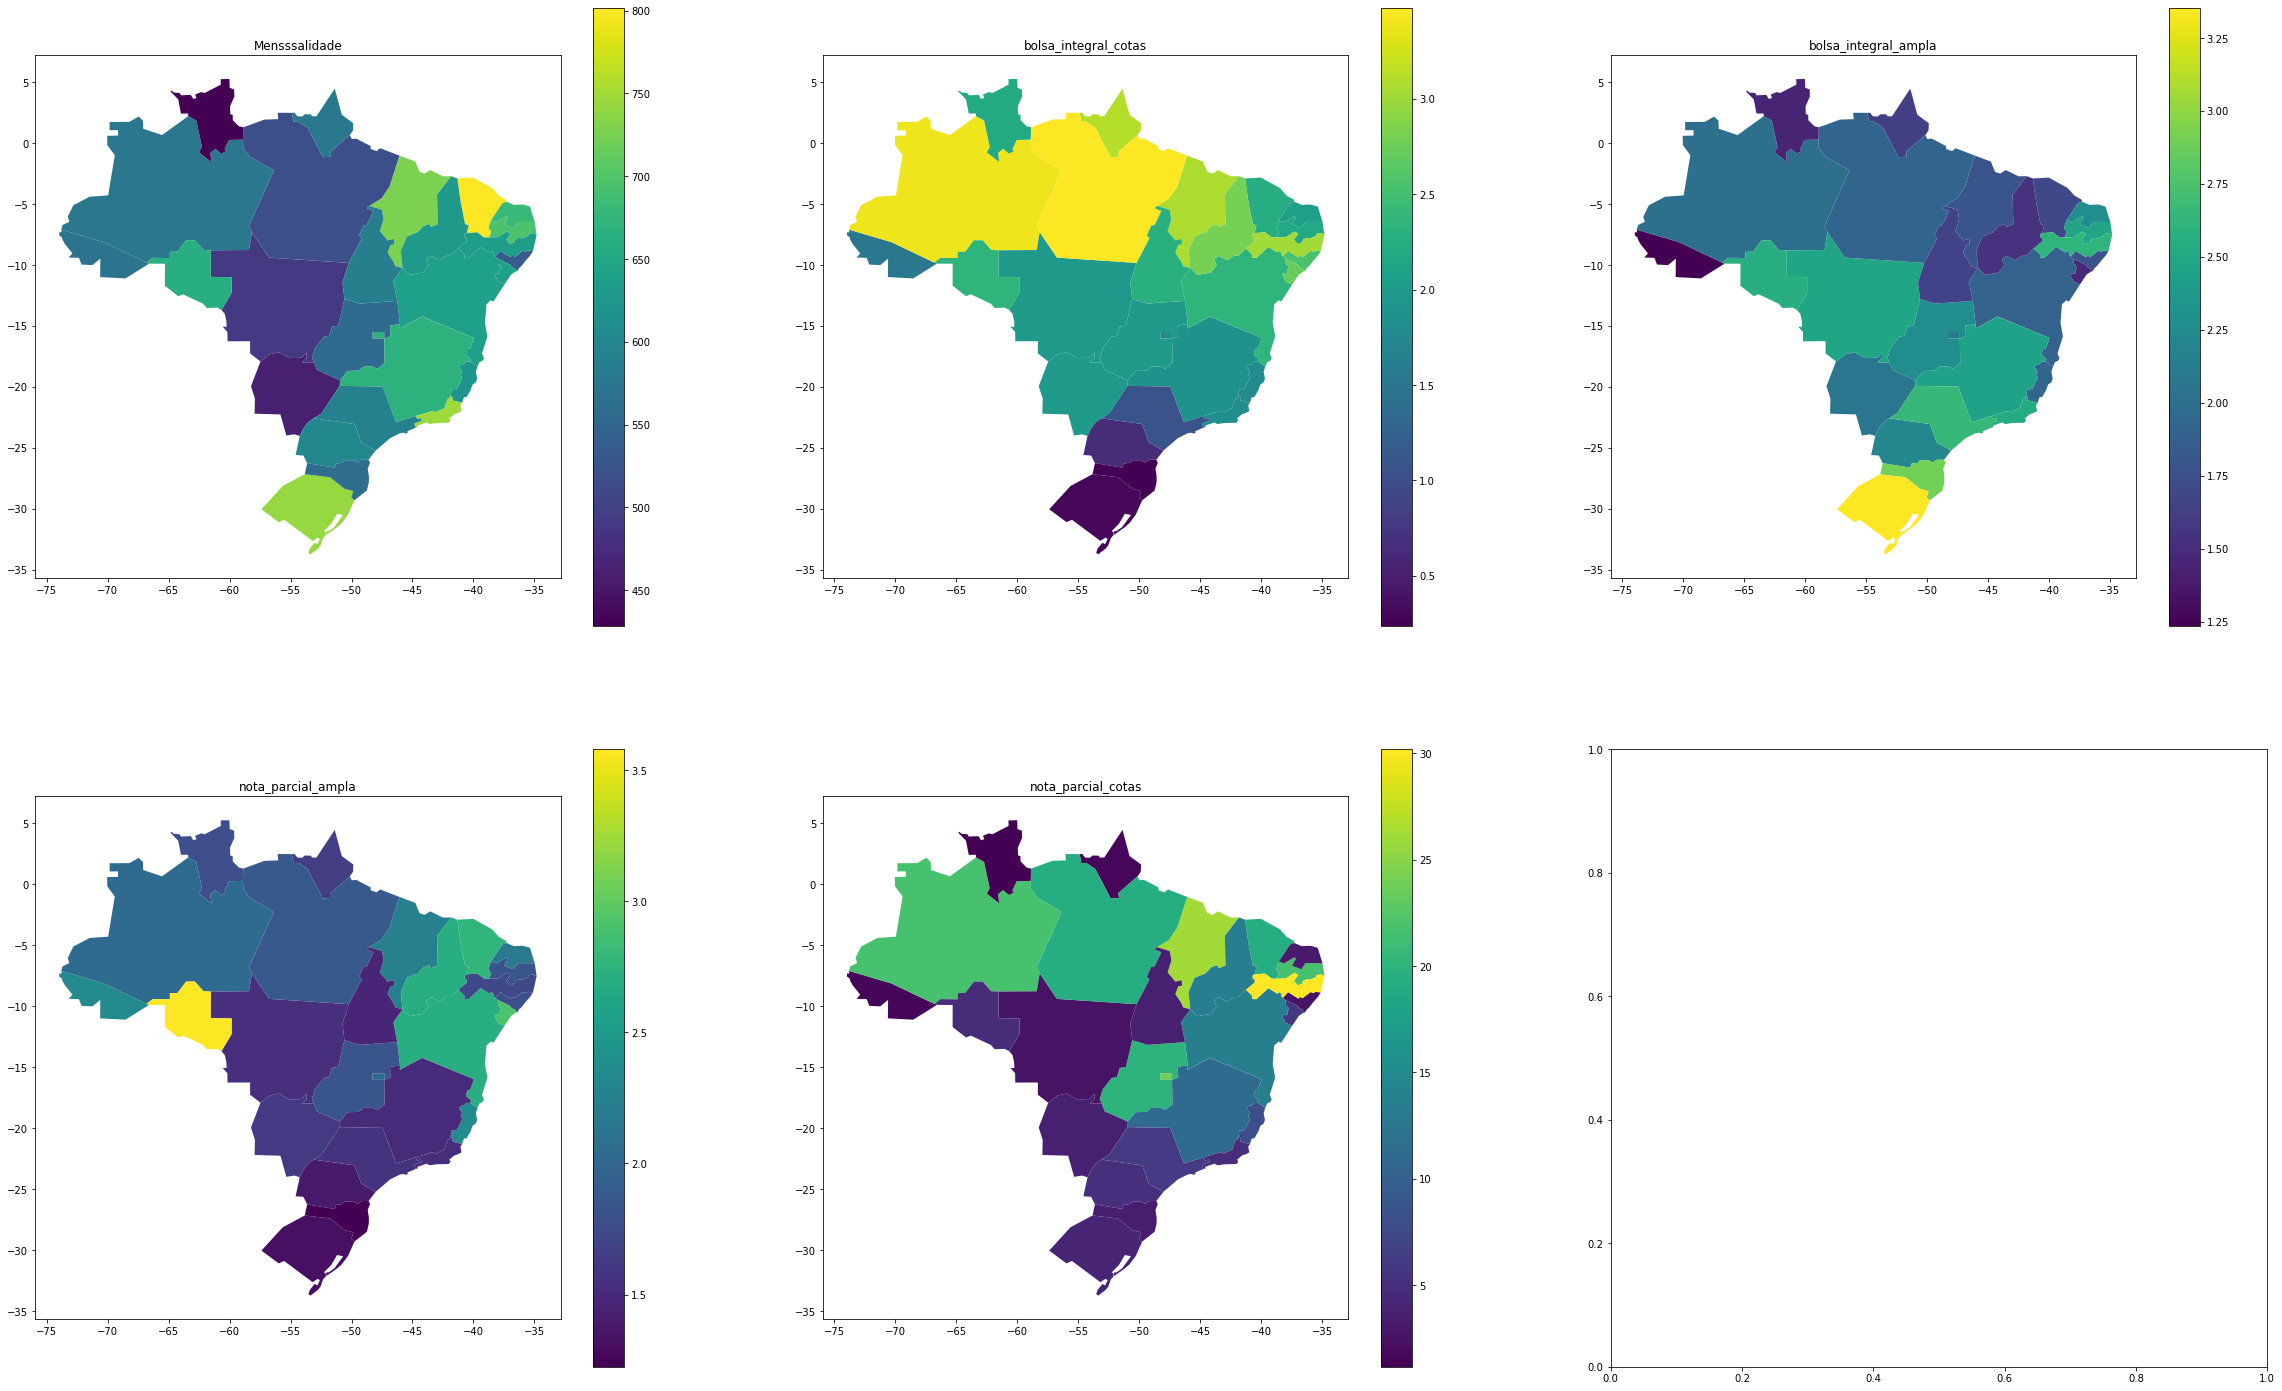

In [27]:
df1=df.groupby("id").mean()

df3=pd.merge(df1,geodata,on="id")
gdf3 = geopandas.GeoDataFrame(
    df3, geometry=df3["geometry"])
gdf3.plot()

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=[40,25])

axes[0][0].set_title("Mensssalidade")
axes[0][1].set_title("bolsa_integral_cotas")
axes[0][2].set_title("bolsa_integral_ampla")
axes[1][0].set_title("nota_parcial_ampla")
axes[1][1].set_title("nota_parcial_cotas")

gdf3.plot(column="mensalidade", ax=axes[0][0], legend=True)
gdf3.plot(column="bolsa_integral_cotas", ax=axes[0][1], legend=True)
gdf3.plot(column="bolsa_integral_ampla", ax=axes[0][2], legend=True)
gdf3.plot(column="bolsa_parcial_cotas", ax=axes[1][0], legend=True)
gdf3.plot(column="bolsa_parcial_ampla", ax=axes[1][1], legend=True)

In [28]:
conn = sqlite3.connect('database_teste')
c = conn.cursor()

In [29]:
geodata = geodata.astype('str', copy=True, errors='raise')

In [30]:
c.execute('CREATE TABLE IF NOT EXISTS estados_geojson (id number, uf text, nome text, geometry text)')
conn.commit()
geodata.to_sql('estadosBr', conn, if_exists='replace', index = False)
conn.commit()

In [109]:
c.execute('''  
SELECT * FROM estadosBr
          ''')

dfaaa = pd.DataFrame(c.fetchall())
print (dfaaa.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       27 non-null     object
 1   1       27 non-null     object
 2   2       27 non-null     object
dtypes: object(3)
memory usage: 776.0+ bytes
None


In [110]:
dfaaa[2] = geopandas.GeoSeries.from_wkt(dfaaa[2])
gdfaaa = geopandas.GeoDataFrame(dfaaa, geometry=2)
print(gdfaaa.info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   0       27 non-null     object  
 1   1       27 non-null     object  
 2   2       27 non-null     geometry
dtypes: geometry(1), object(2)
memory usage: 776.0+ bytes
None


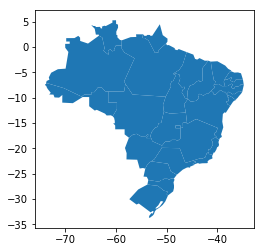

In [111]:
gdfaaa.plot()